In [17]:
from surprise import Dataset, Reader, SVD, SVDpp
from surprise import BaselineOnly, KNNBasic, Dataset
from surprise.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

# Обработка данных

In [3]:
# Загрузка данных
data_df = pd.read_csv('../datasets/movies-dataset/ratings_small.csv')
metadata = pd.read_csv('../datasets/own-dataset/movies.csv', low_memory=False)
metadata.id = pd.to_numeric(metadata.id, errors='coerce')

In [5]:
# Убираем рейтинги на несуществующие фильмы
data_df = data_df[data_df.movieId.isin(metadata.id)]

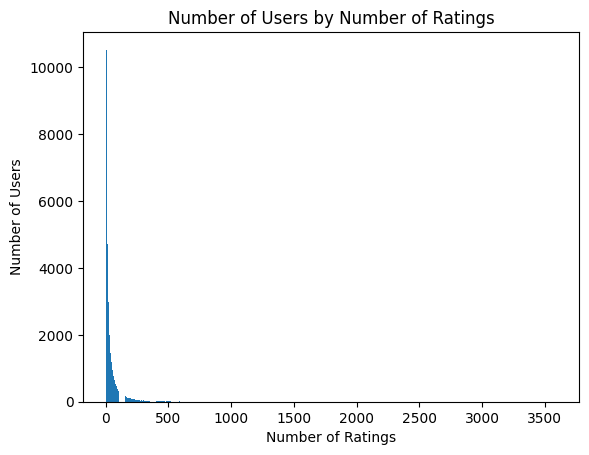

In [202]:
ratings_count = data_df.groupby('userId')['rating'].count()
users_count = ratings_count.groupby(ratings_count).count()

plt.bar(users_count.index, users_count.values)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Number of Users by Number of Ratings')
plt.show()

In [6]:
reader = Reader(line_format='user item rating',  sep='\t', rating_scale=(1, 5))

In [7]:
data = Dataset.load_from_df(data_df[['userId', 'movieId', 'rating']], reader)

# Обучение

### Ищем оптимальные параметры для SVD

In [188]:
param_grid = {
    'n_factors': [100, 200, 300, 400],
    'n_epochs': [10, 43, 75, 100],
    'lr_all': [0.001, 0.01, 0.05],
    'reg_all': [0.02, 0.1, 0.2],
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
grid_search.fit(data)

In [189]:
best_params = grid_search.best_params['rmse']
print("Best params:", best_params)
print("RMSE score:", grid_search.best_score['rmse'])

Best params: {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE score: 0.8766008248837884


### Сравнение с другими алгоритмами

In [105]:
# Базовая модель, предсказывающая средний рейтинг
algo_base = BaselineOnly()
results_base = cross_validate(algo_base, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8960  0.8900  0.9017  0.8990  0.8948  0.8963  0.0040  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.01    0.01    0.01    0.10    0.01    0.03    0.03    


In [106]:
# Базовая модель, основанная на KNN
algo_knn = KNNBasic()
results_knn = cross_validate(algo_knn, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9632  0.9591  0.9629  0.9464  0.9432  0.9550  0.0085  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.21    0.23    0.25    0.23    0.21    0.23    0.01    


In [154]:
algo_svdpp = SVDpp(n_factors=200, n_epochs=35, lr_all=0.01, reg_all=0.1)

In [155]:
algo_svdpp = cross_validate(algo_svdpp, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8773  0.8726  0.8840  0.8738  0.8781  0.8772  0.0040  
Fit time          28.29   28.18   28.31   28.45   28.28   28.30   0.09    
Test time         0.54    0.55    0.55    0.54    0.54    0.54    0.00    


### Обучение модели SVD на лучших параметрах

In [8]:
# Разделение данных на обучающую и тестовую выборки
full_train_set = data.build_full_trainset()

# Обучение модели с лучшими параметрами на обучающей выборке
model = SVD(n_epochs=35, lr_all=0.01, reg_all=0.1)
model.fit(full_train_set)

### Сохранение модели SVD

In [223]:
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Использование модели 

### Получение лучших N фильмов для существующего пользователя

In [237]:
def get_top_n_movies(user_id, n = 10):
    # Берем только те фильмы, которые пользователь еще не оценил
    items_to_predict = [item for item in trainset.build_anti_testset() if item[0] == user_id]

    # Предсказываем их оценки
    predictions = model.test(items_to_predict)

    # Сортировка предсказанных рейтингов по убыванию
    top_n_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Получение идентификаторов фильмов и предсказанных рейтингов
    recommendations = [(pred.iid, pred.est) for pred in top_n_recommendations]
    
    return recommendations

get_top_n_movies(196, n = 3)

[(44555, 4.49475397327648),
 (1262, 4.480729482729906),
 (745, 4.420916124923656)]